In [1]:
import numpy as np
from dobbel import dobbellogger
from help_functies import *
from calibrator import calibrate
import matplotlib.pyplot as plt
dob = dobbellogger()

In [148]:
cali = calibrate(dob)
gyro_bias = cali['gyro bias']
acc_bias = cali['acc bias']
acc_std = cali['acc std']
gyro_std = cali['gyro std']

Leg de dobbelsteen met nummer  1  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  2  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  3  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf


In [149]:
print(cali)

{'gyro bias': array([-0.15100804,  0.46037856,  0.31638869]), 'acc bias': array([-0.00080142,  0.02805087, -0.04472256]), 'gyro std': array([0.47551232, 0.20610885, 2.64408715]), 'acc std': array([0.0023304 , 0.00164414, 0.00210621])}


In [163]:
dob.connect()
dob.log(5, 100, 4, 2000)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [164]:
# Deze code niet vaker dan 1 keer uitvoeren!
data = remove_nan(data)
data = rotate_data(data)

data['x_gyro'] = data['x_gyro'] - gyro_bias[0]
data['y_gyro'] = data['y_gyro'] - gyro_bias[1]
data['z_gyro'] = data['z_gyro'] - gyro_bias[2]
data['x_acc'] = data['x_acc'] - acc_bias[0]
data['y_acc'] = data['y_acc'] - acc_bias[1]
data['z_acc'] = data['z_acc'] - acc_bias[2]

In [165]:
data.head(2000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,-0.007412,-0.048925,1.016964,-0.038540,-0.216476,-0.469881
1,8.0,-0.006333,-0.050512,1.028047,0.026875,0.149378,-0.259988
2,19.0,-0.006152,-0.051488,1.023168,-0.067899,0.027426,-0.336734
3,29.0,-0.007485,-0.053564,1.022874,0.103621,0.027426,-0.354762
4,39.0,-0.006364,-0.053441,1.023624,-0.067899,-0.094525,-0.336734
...,...,...,...,...,...,...,...
497,4876.0,-0.005872,-0.055028,1.024180,0.056234,0.027426,-0.393135
498,4886.0,-0.004444,-0.052953,1.024550,-0.029526,0.027426,-0.384121
499,4897.0,-0.006451,-0.052709,1.025282,-0.124300,0.149378,-0.460868
500,4907.0,-0.007748,-0.054784,1.028630,-0.067899,-0.033549,-0.336734


In [166]:
for column in data.columns:
    print(column, np.mean(data[column]))

timestamp 2466.011952191235
x_acc -0.008090646936146249
y_acc -0.05249502787854267
z_acc 1.0256096352393695
x_gyro 0.005284775149831648
y_gyro -0.0027114392092582543
z_gyro -0.36447017490273287


In [167]:
y11 = np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
ymb= np.array([1, 2, 3])
mb = np.cross(gb, np.cross(ymb / np.linalg.norm(ymb), gb))

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) #- np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]
q11 = max_eigenvector

In [168]:
q11 = max_eigenvector

dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11 = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))
v1 = np.array([0,0,0])
p1 = np.array([0,0,0])

In [169]:
qtmin1tmin1 = np.reshape(q11, 4)
Ptmin1tmin1 = P11
vtmin1 = v1
ptmin1 = p1

q_list = [qtmin1tmin1]
v_list = [vtmin1]
p_list = [ptmin1]


Q = np.array([
    [gyro_std[0] ** 2, 0, 0],
    [0, gyro_std[1] ** 2, 0],
    [0, 0, gyro_std[2] ** 2]
])

R = np.array([
    [acc_std[0] ** 2, 0, 0],
    [0, acc_std[1] ** 2, 0],
    [0, 0, acc_std[2] ** 2],
])

epsilon_list = []

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)

    Ftmin1 = right_quat_mul(expq_omega)
    Gtmin1 = - 0.5 * dt * np.matmul(left_quat_mul(qtmin1tmin1), dqde)
    Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)
    qttmin1 = quat_mul(qtmin1tmin1, expq_omega)
    
    q0, q1, q2, q3 = qttmin1
    H = 2 * np.array([
        [-q2, q3, -q0, q1],
        [q1, q0, q3, q2],
        [2 * q0, 0, 0, 2 * q3]
    ])

    S = np.matmul(np.matmul(H, Pttmin1), H.T) + R
    K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))

    yat = np.array([data['x_acc'][i], data['y_acc'][i], data['z_acc'][i]])
    yattmin1 = rotate_vector(gn, quaternion_conjugate(qttmin1))
    yateps = yat / np.linalg.norm(yat)
    epsilon = yateps - yattmin1
    q_tt_measure = np.reshape(qttmin1, (4, 1)) + np.matmul(K, np.reshape(epsilon, (3, 1)))
    Ptt = Pttmin1 - np.matmul(np.matmul(K, H), Pttmin1)
    qtt = q_tt_measure / ((np.linalg.norm(q_tt_measure)))
    
    an = rotate_vector(yat, np.reshape(qtt, 4)) - gn
    an = an * 9.81
    print(an)
    vt = vtmin1 + dt * an
    pt = ptmin1 + dt * vtmin1 + 0.5 * an * dt ** 2 

    Ptmin1tmin1 = Ptt
    qtmin1tmin1 = np.reshape(qtt, 4)
    ptmin1 = pt
    vtmin1 = vt

    q_list.append(qtmin1tmin1)
    epsilon_list.append(epsilon)
    p_list.append(ptmin1)
    v_list.append(vtmin1)

[ 4.87729095e-07 -1.33249254e-09  2.87498187e-01]
[-0.0004079   0.00097382  0.24015577]
[0.00467746 0.00205342 0.23840628]
[-2.21153521e-03  6.99206570e-05  2.45619477e-01]
[0.00908428 0.00140272 0.26135973]
[0.00621046 0.00104435 0.28009242]
[0.00286777 0.00030188 0.27101663]
[-0.00918986  0.00036922  0.26808018]
[-0.00201927 -0.00097771  0.26451676]
[-0.00705478 -0.00510711  0.25824847]
[-0.0118806  -0.00107616  0.23416554]
[0.00297716 0.00113626 0.23272055]
[0.00067051 0.00098586 0.24328095]
[ 0.00728247 -0.00049716  0.24597536]
[0.00532356 0.00429352 0.23405738]
[0.00524895 0.00286075 0.24069053]
[0.00874513 0.00171637 0.2672341 ]
[ 0.00360579 -0.00051618  0.27295833]
[-0.00248614  0.00035998  0.25406837]
[-0.00445327 -0.00282243  0.26170228]
[-0.00164896  0.00060405  0.2501774 ]
[-0.01302754  0.00029933  0.22801764]
[-0.00254621 -0.00094966  0.24265612]
[ 7.22902460e-03 -6.09960638e-05  2.47559590e-01]
[-0.00547422 -0.00046885  0.26956079]
[0.00432052 0.00039837 0.2435772 ]
[0.007

In [170]:
rotvec_x = []
rotvec_y = []
rotvec_z = []

for q, timestamp in zip(q_list, data['timestamp']):
    euler = quaternion_to_euler(q) * 180 / np.pi
    rotvec_x.append(euler[0])
    rotvec_y.append(euler[1])
    rotvec_z.append(euler[2])

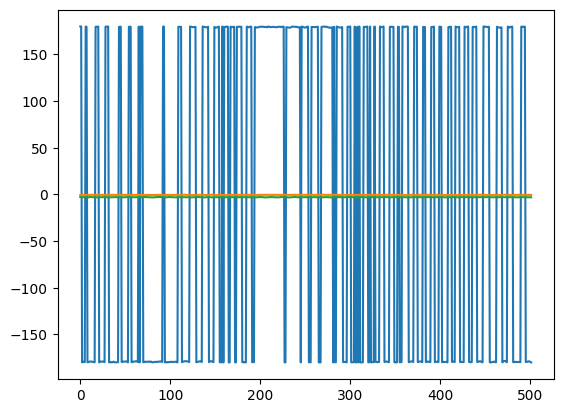

In [171]:
plt.plot(rotvec_x)
plt.plot(rotvec_y)
plt.plot(rotvec_z)

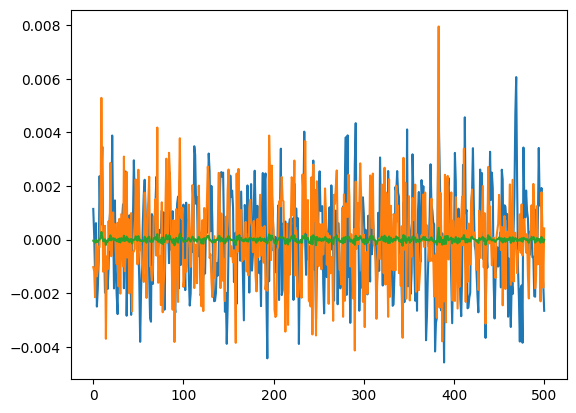

In [172]:
epsilons = np.concatenate(epsilon_list)
epsilons = np.reshape(epsilons, (int(len(epsilons) / 3), 3))

plt.plot(epsilons[:, 0])
plt.plot(epsilons[:, 1])
plt.plot(epsilons[:, 2])

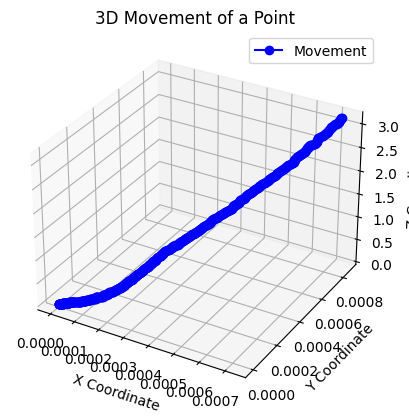

In [173]:
positions = np.reshape(np.concatenate(p_list), (int(len(p_list)), 3))
# Create a new figure for the 3D plot
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the movement of the point
ax.plot(positions[:,0], positions[:,1], positions[:,2], marker='o', linestyle='-', color='b', label='Movement')

# Set labels for each axis
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set a title
ax.set_title('3D Movement of a Point')

# Add a legend
ax.legend()

# Show the plot
plt.show()


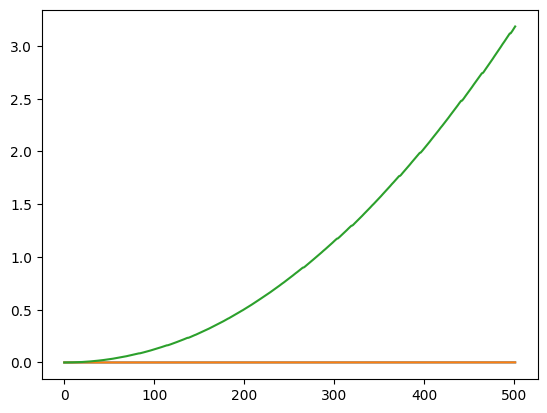

In [174]:
plt.plot(positions[:,0])
plt.plot(positions[:,1])
plt.plot(positions[:,2])
plt.show()